Download the dataset from the following link:
https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?select=chest_xray

# Part 1: Image loading and preprocessing

In [1]:
import zipfile
import glob
import cv2
import matplotlib.pyplot as plt

import numpy as np



In [2]:
def img_preprocess(img):
  img=cv2.imread(img)
  img= cv2.resize(img, (100,75))
  img= img/255.0
  return img

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
with zipfile.ZipFile('/content/drive/MyDrive/x-ray.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

## Prepare training dataset and preprocess images

In [5]:
normal_files_paths= glob.glob(r'/content/chest_xray/chest_xray/train/NORMAL/*.jpeg')
pneu_files_paths= glob.glob(r'/content/chest_xray/chest_xray/train/PNEUMONIA/*.jpeg')


In [6]:
normal_files_paths_val=glob.glob(r'/content/chest_xray/chest_xray/val/NORMAL/*jpeg')
pneu_files_paths_val=glob.glob(r'/content/chest_xray/chest_xray/val/PNEUMONIA/*jpeg')

In [7]:
normal_files_paths_test=glob.glob(r'/content/chest_xray/chest_xray/test/NORMAL/*jpeg')
pneu_files_paths_test=glob.glob(r'/content/chest_xray/chest_xray/test/PNEUMONIA/*jpeg')

In [8]:
normal_files_paths= normal_files_paths+normal_files_paths_test+normal_files_paths_val

In [9]:
pneu_files_paths=pneu_files_paths+pneu_files_paths_test+pneu_files_paths_val

In [10]:
normal_images=[]


for files in normal_files_paths:
  img=img_preprocess(files)
  normal_images.append(img)
normal_images=np.array(normal_images)


In [11]:
pneu_images=[]
for files in pneu_files_paths:
  img=img_preprocess(files)
  pneu_images.append(img)
pneu_images=np.array(pneu_images)

In [12]:
X=np.vstack((normal_images,pneu_images))
X.shape

(5856, 75, 100, 3)

In [13]:
#create labels
labels1= np.zeros(len(normal_files_paths))
labels2 = np.ones(len(pneu_files_paths))
y= np.hstack((labels1, labels2))



---
#Part 2: Neural Network Part

In [14]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




In [15]:

y = to_categorical(y)

In [16]:

# First split to create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# Second split to create training and validation sets from the training set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


#test

In [17]:
#define Convolutional Neura Network
def Conv_model():
    model= models.Sequential()
    model.add(layers.Conv2D(30,(3,3),input_shape=(75,100,3),activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))

    model.add(layers.Conv2D(60, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(120, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=0.0001 ), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model= Conv_model()
print(model.summary())

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=12)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 98, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2  (None, 36, 49, 30)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 47, 60)        16260     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 23, 60)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 21, 120)       64920     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 7, 10, 120)        0

Text(0.5, 0, 'epoch')

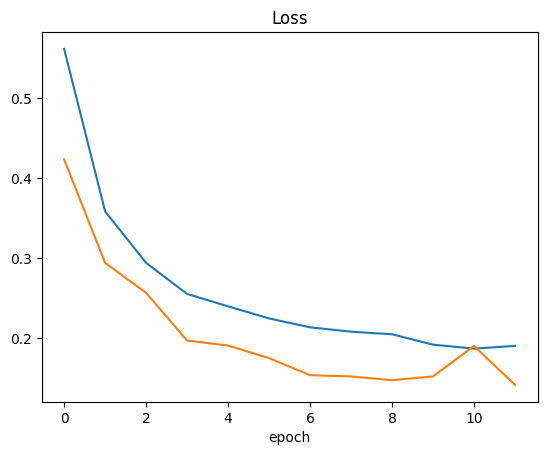

In [18]:
#create chart of progress
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

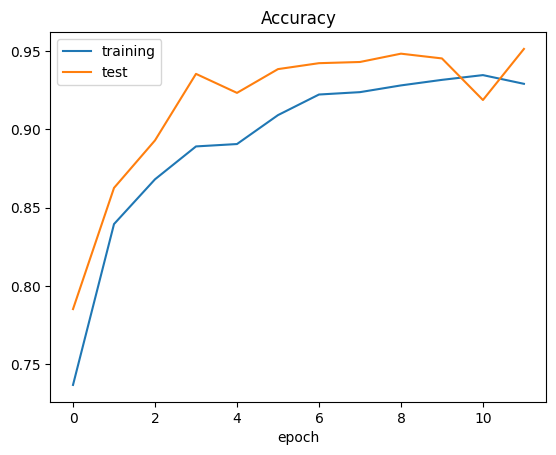

In [19]:
#Plot performance(accuracy) per epoch

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [20]:
# Assuming you have already imported the necessary libraries and trained your model

# Test the model on the test set
y_pred = model.predict(X_test)

# Evaluate the model performance

y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)





19/19 [==============================] - 0s 13ms/step


In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9522184300341296
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       177
           1       0.95      0.98      0.97       409

    accuracy                           0.95       586
   macro avg       0.95      0.93      0.94       586
weighted avg       0.95      0.95      0.95       586

Confusion Matrix:
[[157  20]
 [  8 401]]


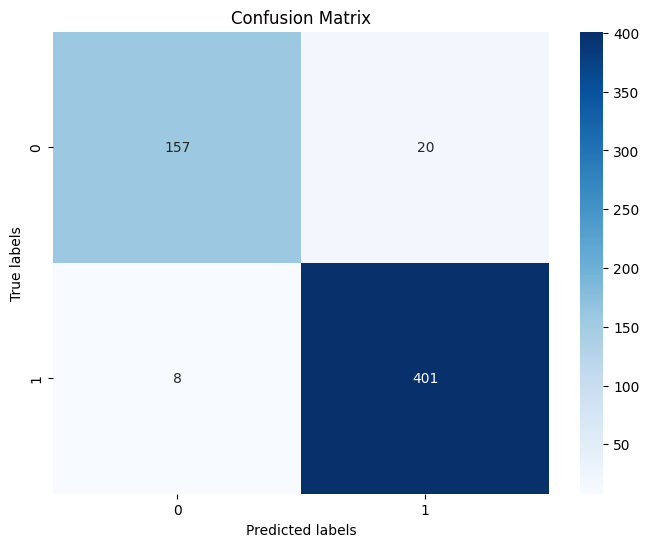

In [22]:
import seaborn as sns

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

